# Inspect pyo

In [ ]:
import pyo 

len(dir(pyo)) 

859

In [ ]:
import tec
import pyo 

is_pyoobj_subclass = lambda o: isinstance(o, type) and issubclass(o, pyo.PyoObject) and o != pyo.PyoObject
pyobj_classes = dict(tec.name_and_object_pairs(pyo, obj_filt=is_pyoobj_subclass))
len(pyobj_classes)


239

In [ ]:
# Note: All PyoObject subclasses are direct subclasses of PyoObject
assert all(v.mro()[1] == pyo.PyoObject for v in pyobj_classes.values()), (
    "Not all values are PyoObject or subclass of PyoObject"
)

In [ ]:
list(pyobj_classes)

['AToDB',
 'Abs',
 'Adsr',
 'Allpass',
 'Allpass2',
 'AllpassWG',
 'ArithmeticDummy',
 'Atan2',
 'Atone',
 'AttackDetector',
 'Average',
 'Balance',
 'BandSplit',
 'Beat',
 'Bendin',
 'Between',
 'Binaural',
 'Biquad',
 'Biquada',
 'Biquadx',
 'Blit',
 'BrownNoise',
 'ButBP',
 'ButBR',
 'ButHP',
 'ButLP',
 'CallAfter',
 'CarToPol',
 'Ceil',
 'Centroid',
 'CentsToTranspo',
 'Change',
 'ChenLee',
 'Choice',
 'Chorus',
 'Clip',
 'Cloud',
 'Compare',
 'ComplexRes',
 'Compress',
 'ControlRead',
 'ControlRec',
 'Convolve',
 'Cos',
 'Count',
 'Counter',
 'CrossFM',
 'CtlScan',
 'CtlScan2',
 'CvlVerb',
 'DBToA',
 'DCBlock',
 'Degrade',
 'Delay',
 'Delay1',
 'Denorm',
 'Disto',
 'Div',
 'Dummy',
 'EQ',
 'Euclide',
 'Exp',
 'Expand',
 'Expr',
 'Expseg',
 'FFT',
 'FM',
 'FToM',
 'Fader',
 'FastSine',
 'Floor',
 'Follower',
 'Follower2',
 'FourBand',
 'FrameAccum',
 'FrameDelta',
 'Freeverb',
 'FreqShift',
 'Gate',
 'Granulator',
 'Granule',
 'HRTF',
 'Harmonizer',
 'Hilbert',
 'IFFT',
 'IFFTMatri

# Versions of the Synth

## A simple abstract Synth

In [ ]:
# Wrapper to encapsulate value and time (optional)
class SigControl:
    def __init__(self, value=None, time=None):
        self.value = value
        self.time = time

# Wraps a SigTo object for intuitive control
class SigWrapper:
    def __init__(self, sigto_obj):
        self._sig = sigto_obj

    def __call__(self, val):
        self._sig.value = val

    def update(self, val):
        if isinstance(val, SigControl):
            if val.time is not None:
                self._sig.time = val.time
            if val.value is not None:
                self._sig.value = val.value
        else:
            self._sig.value = val

    def __getattr__(self, name):
        return getattr(self._sig, name)

    def __setattr__(self, name, val):
        if name in {"value", "time"}:
            setattr(self._sig, name, val)
        elif name == "_sig":
            super().__setattr__(name, val)
        else:
            raise AttributeError(f"Cannot set {name} on SigWrapper")

    def __repr__(self):
        return f"<SigWrapper value={self._sig.value}, time={self._sig.time}>"

# Container to simplify parameter control
class ParamSet:
    def __init__(self, param_dict):
        self._params = {k: SigWrapper(v) for k, v in param_dict.items()}

    def __getitem__(self, key):
        return self._params[key]

    def __setitem__(self, key, value):
        self._params[key].update(value)



class Synth3:
    def __init__(self, graph_func, param_specs):
        self.server = Server(audio='portaudio').boot()
        self.server.start()

        # Create SigTo controls
        raw_params = {
            name: SigTo(value=spec['value'], time=spec.get('time', 0.05))
            for name, spec in param_specs.items()
        }
        self.sound_params = ParamSet(raw_params)

        # Generate audio graph using the provided function
        self.output = graph_func(raw_params).out()

    def start(self):
        self.output.out()
        self.server.start()
        return self

    def stop(self):
        self.output.stop()
        self.server.stop()

    def __del__(self):
        self.server.stop()

    __enter__ = start
    
    def __exit__(self, exc_type, exc_value, traceback):
        self.stop()





In [ ]:
def synth_graph(params):
    osc = Sine(freq=params['freq'])
    lfo = Sine(freq=params['tempo'] / 60.0).range(0.2, 1.0)
    modulated = osc * params['amp'] * lfo
    return ButLP(modulated, freq=params['cutoff'])


param_specs = {
    'freq': {'value': 440, 'time': 0.05},
    'amp': {'value': 0.5},
    'cutoff': {'value': 1000},
    'tempo': {'value': 120},
}

obj = Synth3(synth_graph, param_specs)

Pyo warning: Portaudio input device `MacBook Pro Microphone` has fewer channels (1) than requested (2).
Pyo warning: Portmidi warning: could not open midi input 0 (IAC Driver Bus 1): PortMidi: Invalid device ID
Pyo warning: Portmidi warning: could not open midi output 1 (IAC Driver Bus 1): PortMidi: Invalid device ID
Pyo warning: Portmidi closed.
Pyo warning: The Server must be started!


In [ ]:
obj.sound_params['freq'] = 1200


In [ ]:
obj.sound_params['cutoff'] = 200  # Very muffled


In [ ]:
obj.sound_params['cutoff'] = SigControl(value=4000, time=1.0)  # Slowly brightens

In [ ]:
obj.stop()

## A concrete version of Synth

In [ ]:
from pyo import *

# Wrapper to encapsulate value and time (optional)
class SigControl:
    def __init__(self, value=None, time=None):
        self.value = value
        self.time = time

# Wraps a SigTo object for intuitive control
class SigWrapper:
    def __init__(self, sigto_obj):
        self._sig = sigto_obj

    def __call__(self, val):
        self._sig.value = val

    def update(self, val):
        if isinstance(val, SigControl):
            if val.time is not None:
                self._sig.time = val.time
            if val.value is not None:
                self._sig.value = val.value
        else:
            self._sig.value = val

    def __getattr__(self, name):
        return getattr(self._sig, name)

    def __setattr__(self, name, val):
        if name in {"value", "time"}:
            setattr(self._sig, name, val)
        elif name == "_sig":
            super().__setattr__(name, val)
        else:
            raise AttributeError(f"Cannot set {name} on SigWrapper")

    def __repr__(self):
        return f"<SigWrapper value={self._sig.value}, time={self._sig.time}>"

# Container to simplify parameter control
class ParamSet:
    def __init__(self, param_dict):
        self._params = {k: SigWrapper(v) for k, v in param_dict.items()}

    def __getitem__(self, key):
        return self._params[key]

    def __setitem__(self, key, value):
        self._params[key].update(value)

# Main synth class
class Synth2:
    def __init__(self, freq=440, amp=0.5, cutoff=1000, tempo=120):
        self.server = Server(audio='portaudio').boot()
        self.server.start()

        # Create SigTo parameters
        raw_params = {
            'freq': SigTo(value=freq, time=0.05),
            'amp': SigTo(value=amp, time=0.05),
            'cutoff': SigTo(value=cutoff, time=0.05),
            'tempo': SigTo(value=tempo, time=0.05),
        }

        self.sound_params = ParamSet(raw_params)

        # Synth processing chain
        osc = Sine(freq=raw_params['freq'])
        lfo = Sine(freq=raw_params['tempo'] / 60.0).range(0.2, 1.0)
        modulated = osc * raw_params['amp'] * lfo
        self.filtered = ButLP(modulated, freq=raw_params['cutoff'])

        self.output = self.filtered.out()

    def start(self):
        self.output.out()
        self.server.start()

    def stop(self):
        self.output.stop()
        self.server.stop()

    def __del__(self):
        self.server.stop()

In [ ]:
obj = Synth2()

Pyo warning: Portaudio input device `MacBook Pro Microphone` has fewer channels (1) than requested (2).
Pyo warning: The Server must be started!


In [ ]:
obj.sound_params['freq'] = 660  # Smoothly changes freq

In [ ]:
obj.sound_params['freq'] = SigControl(value=200, time=0.8)  # Custom time

In [ ]:
obj.sound_params['amp'].time = 0.3  # Change ramp time


In [ ]:
obj.sound_params['tempo'] = 60

In [ ]:
obj.sound_params['tempo'].play()  # Direct access to SigTo methods

< Instance of SigTo class >

In [ ]:
obj.stop()

## A simple, concrete version of Synth

In [ ]:
from pyo import *

class Synth1:
    def __init__(self, freq=440, amp=0.5, cutoff=1000, tempo=120):
        # Boot server in non-GUI, realtime mode
        self.server = Server(audio='portaudio').boot()
        self.server.start()

        # Sound parameters as SigTo for smooth changes
        self.sound_params = {
            'freq': SigTo(value=freq, time=0.05),
            'amp': SigTo(value=amp, time=0.05),
            'cutoff': SigTo(value=cutoff, time=0.05),
            'tempo': SigTo(value=tempo, time=0.05),
        }

        # Oscillator and modulations
        self.osc = Sine(freq=self.sound_params['freq'])
        self.lfo = Sine(freq=self.sound_params['tempo'] / 60.0).range(0.2, 1.0)
        modulated = self.osc * self.sound_params['amp'] * self.lfo
        self.filtered = ButLP(modulated, freq=self.sound_params['cutoff'])

        # Output
        self.output = self.filtered.out()

    def stop(self):
        self.output.stop()
        self.server.stop()

    def start(self):
        self.output.out()
        self.server.start()

    def __del__(self):
        self.server.stop()


In [ ]:
obj = Synth1()

In [ ]:
obj.sound_params['freq'].value = 300

In [ ]:
obj.stop()

In [ ]:
list(obj.sound_params)

['freq', 'amp', 'cutoff', 'tempo']

# Real time synth

In [ ]:
from hum.utils.pyo_util import *
from pyo import *


In [11]:
import recode 

def my_graph(frequency, tempo, amplitude, cutoff):
    osc = Sine(freq=frequency)
    lfo = Sine(freq=tempo / 60.0).range(0.2, 1.0)
    modulated = osc * amplitude * lfo
    return ButLP(modulated, freq=cutoff)

frames = [
    {'tempo': 120, 'frequency': 440, 'amplitude': 0.5, 'cutoff': 1000},
    {'tempo': 135, 'frequency': 330, 'amplitude': 0.7, 'cutoff': 500},
    {'tempo': 100, 'frequency': 550, 'amplitude': 0.3, 'cutoff': 2000},
    {'tempo': 150, 'frequency': 220, 'amplitude': 0.9, 'cutoff': 750},
    {'tempo': 110, 'frequency': 660, 'amplitude': 0.6, 'cutoff': 1500},
]

renderer = OfflineSynthRenderer(
    graph_func=my_graph,
    parameter_frames=frames,
    frame_durations=2.0,
    sr=44100,
    egress=recode.decode_wav_bytes,
)

wf, sr = renderer.render()
assert sr == 44100
assert isinstance(wf, list)
assert len(wf) == int(len(frames) * 2.0 * 44100)
assert isinstance(wf[0], int)


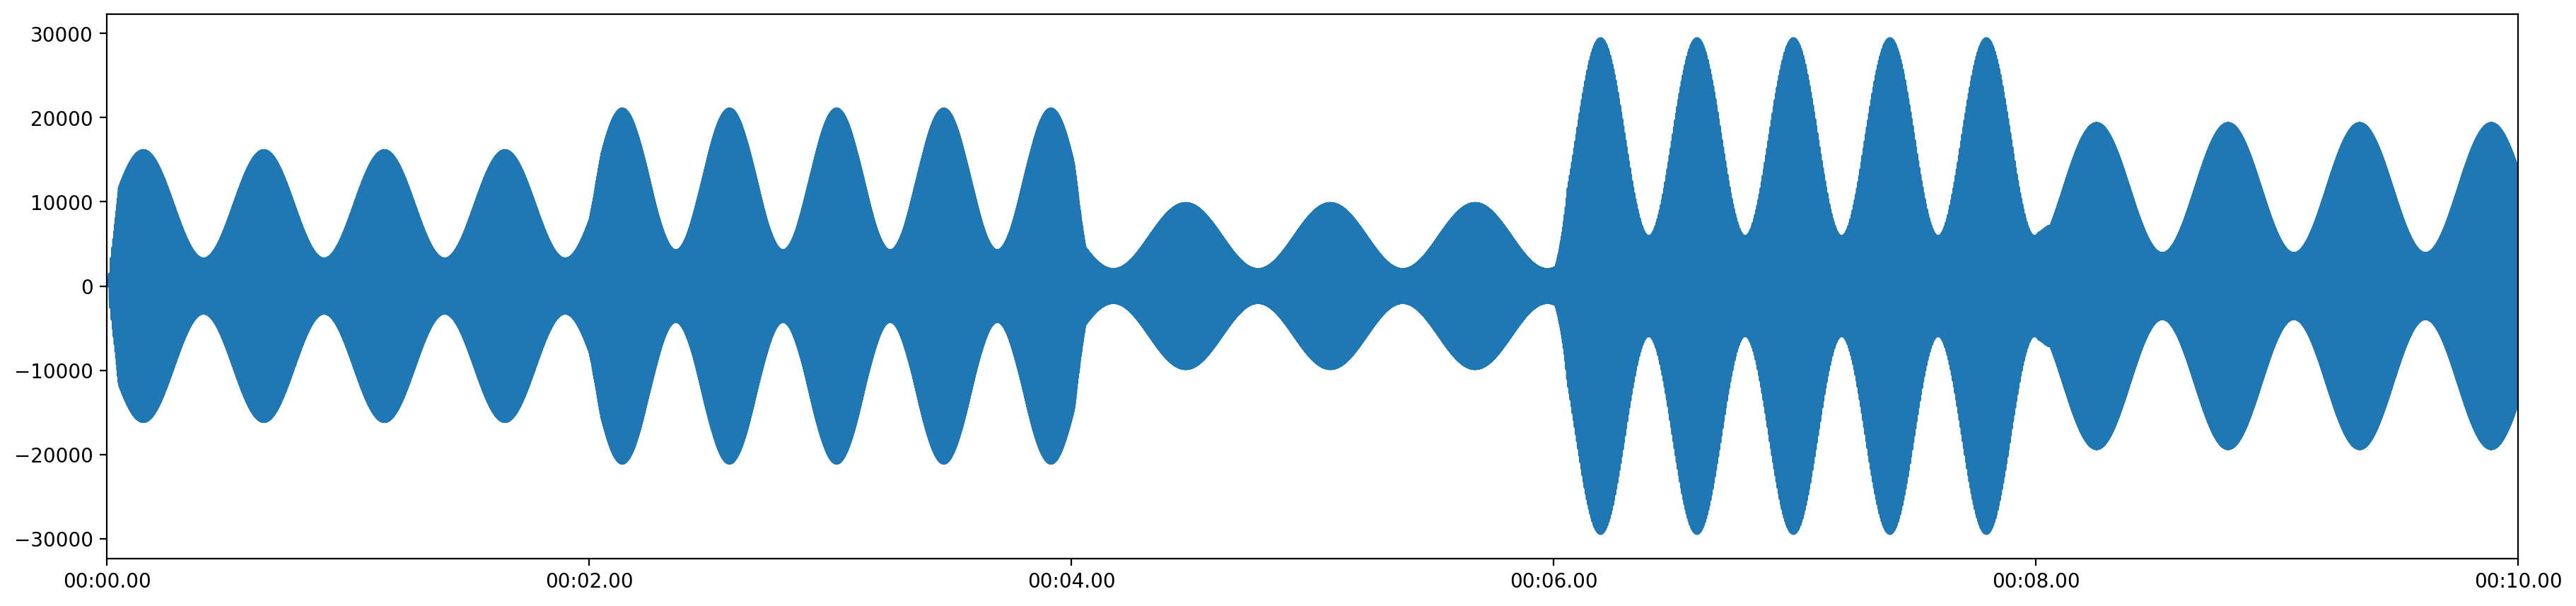

In [46]:
from hum import plot_wf
from IPython.display import Audio

plot_wf(wf, sr)
Audio(wf, rate=sr)

In [ ]:
def my_graph(params):
    osc = Sine(freq=params['frequency'])
    lfo = Sine(freq=params['tempo'] / 60.0).range(0.2, 1.0)
    modulated = osc * params['amplitude'] * lfo
    return ButLP(modulated, freq=params['cutoff'])

frames = [
    {'tempo': 120, 'frequency': 440, 'amplitude': 0.5, 'cutoff': 1000},
    {'tempo': 135, 'frequency': 330, 'amplitude': 0.7, 'cutoff': 500},
    {'tempo': 100, 'frequency': 550, 'amplitude': 0.3, 'cutoff': 2000},
    {'tempo': 150, 'frequency': 220, 'amplitude': 0.9, 'cutoff': 750},
    {'tempo': 110, 'frequency': 660, 'amplitude': 0.6, 'cutoff': 1500},
]

renderer = OfflineSynthRenderer(
    graph_func=my_graph,
    parameter_frames=frames,
    frame_durations=2.0,
    output_filepath="/Users/thorwhalen/tmp/offline_demo.wav"
)

b = renderer.render()
print(f"{len(b)=}, {type(b)=}")

Pyo message: Offline Server rendering file /Users/thorwhalen/pyo_rec.wav dur=2.000000
Pyo message: Offline Server rendering finished.
Pyo message: Offline Server rendering file /Users/thorwhalen/pyo_rec.wav dur=2.000000
Pyo message: Offline Server rendering finished.
Pyo message: Offline Server rendering file /Users/thorwhalen/pyo_rec.wav dur=2.000000
Pyo message: Offline Server rendering finished.
Pyo message: Offline Server rendering file /Users/thorwhalen/pyo_rec.wav dur=2.000000
Pyo message: Offline Server rendering finished.
Pyo message: Offline Server rendering file /Users/thorwhalen/pyo_rec.wav dur=2.000000
Pyo message: Offline Server rendering finished.
len(b)=882044, type(b)=<class 'bytes'>


In [ ]:
from recode import decode_wav_bytes

wf, sr = decode_wav_bytes(b)

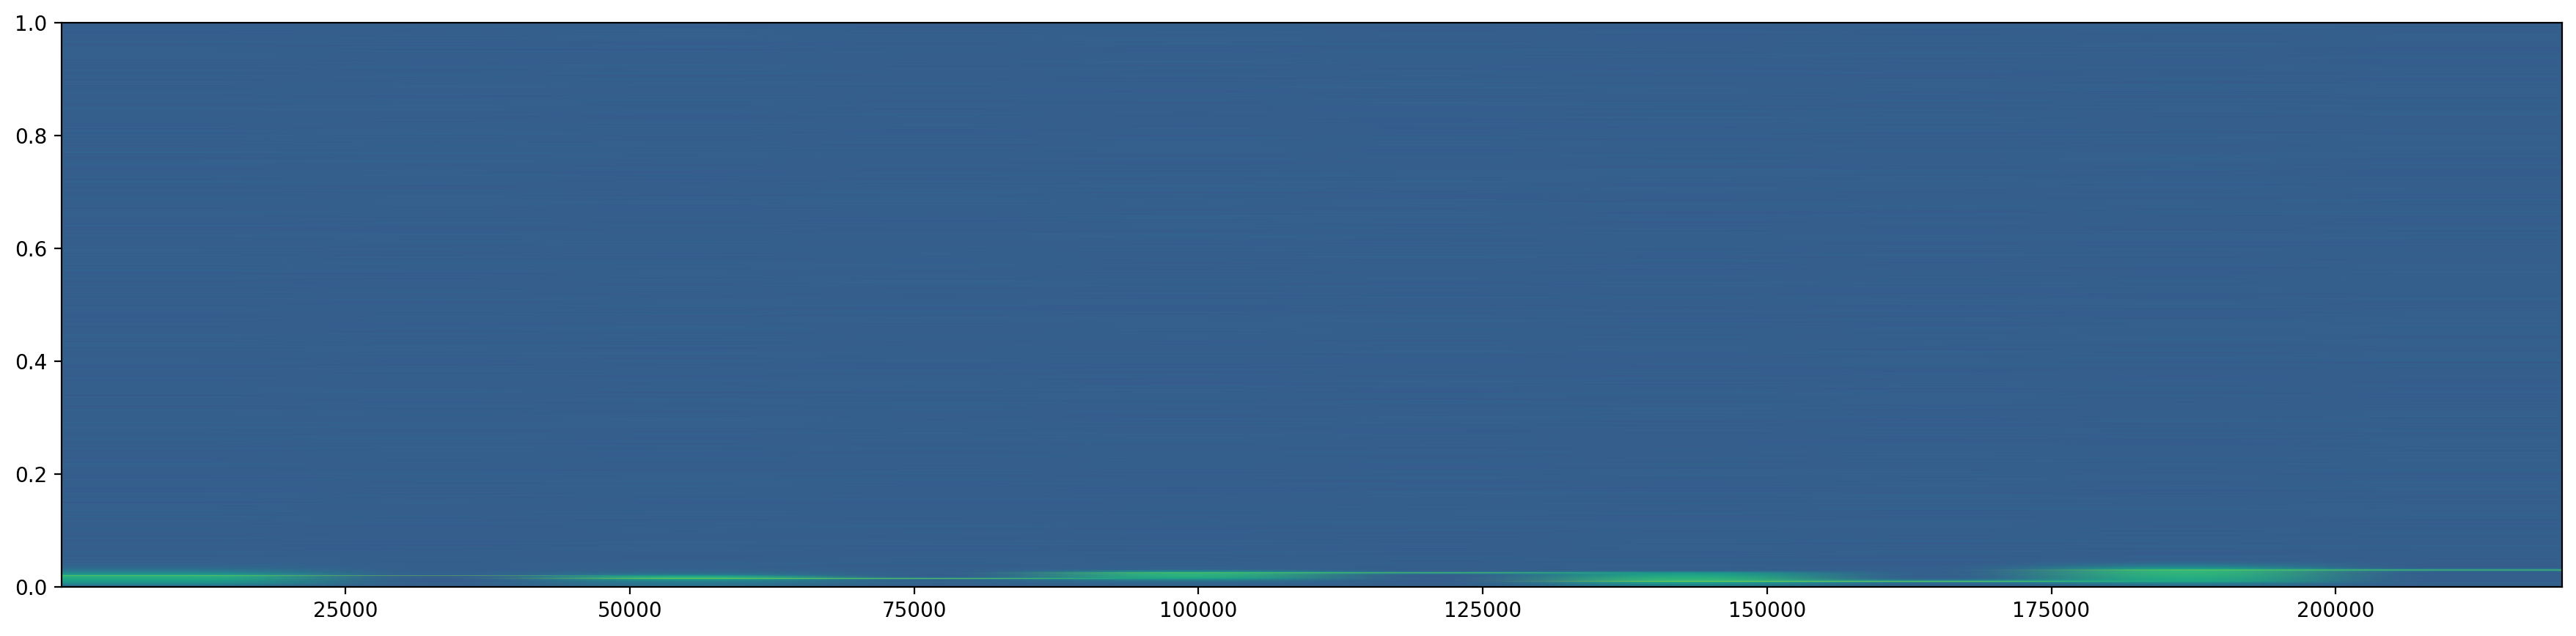

In [ ]:
from hum import disp_wf

disp_wf(wf, sr)

# Inspect pyo

In [ ]:
import pyo 

len(dir(pyo)) 

859

In [ ]:
import tec
import pyo 

is_pyoobj_subclass = lambda o: isinstance(o, type) and issubclass(o, pyo.PyoObject) and o != pyo.PyoObject
pyobj_classes = dict(tec.name_and_object_pairs(pyo, obj_filt=is_pyoobj_subclass))
len(pyobj_classes)


239

In [ ]:
# Note: All PyoObject subclasses are direct subclasses of PyoObject
assert all(v.mro()[1] == pyo.PyoObject for v in pyobj_classes.values()), (
    "Not all values are PyoObject or subclass of PyoObject"
)

In [ ]:
list(pyobj_classes)

['AToDB',
 'Abs',
 'Adsr',
 'Allpass',
 'Allpass2',
 'AllpassWG',
 'ArithmeticDummy',
 'Atan2',
 'Atone',
 'AttackDetector',
 'Average',
 'Balance',
 'BandSplit',
 'Beat',
 'Bendin',
 'Between',
 'Binaural',
 'Biquad',
 'Biquada',
 'Biquadx',
 'Blit',
 'BrownNoise',
 'ButBP',
 'ButBR',
 'ButHP',
 'ButLP',
 'CallAfter',
 'CarToPol',
 'Ceil',
 'Centroid',
 'CentsToTranspo',
 'Change',
 'ChenLee',
 'Choice',
 'Chorus',
 'Clip',
 'Cloud',
 'Compare',
 'ComplexRes',
 'Compress',
 'ControlRead',
 'ControlRec',
 'Convolve',
 'Cos',
 'Count',
 'Counter',
 'CrossFM',
 'CtlScan',
 'CtlScan2',
 'CvlVerb',
 'DBToA',
 'DCBlock',
 'Degrade',
 'Delay',
 'Delay1',
 'Denorm',
 'Disto',
 'Div',
 'Dummy',
 'EQ',
 'Euclide',
 'Exp',
 'Expand',
 'Expr',
 'Expseg',
 'FFT',
 'FM',
 'FToM',
 'Fader',
 'FastSine',
 'Floor',
 'Follower',
 'Follower2',
 'FourBand',
 'FrameAccum',
 'FrameDelta',
 'Freeverb',
 'FreqShift',
 'Gate',
 'Granulator',
 'Granule',
 'HRTF',
 'Harmonizer',
 'Hilbert',
 'IFFT',
 'IFFTMatri

pyo.lib._core.PyoObject

# Appendix: Cool code snippets

## Using generator.send to communicate to the synth

In [9]:
def echo():
    while True:
        value = yield  # Wait for a value to be sent
        print(f"Received: {value}")

# Create a generator
generator = echo()

# Start the generator
next(generator)

# Send values to the generator
generator.send("Hello")
generator.send("World")


class K:
    def __init__(self, generator_func, signature=None):
        self._generator_func = generator_func
        self._generator = generator_func()
        next(self._generator)  # prime the generator 
        if signature:
            self.__signature__ = signature

    def __call__(self, **kwargs):
        return self._generator.send(kwargs)

import i2
k = K(echo, signature=i2.Sig('(*, a=None, b=None, c=None)'))
k(a=1)
k(b=2, c=3)
i2.Sig(k)

Received: Hello
Received: World
Received: {'a': 1}
Received: {'b': 2, 'c': 3}


<Sig (*, a=None, b=None, c=None)>

# Synths

## Interface ideas

```py
synth = Synth(graph_func, *, ...)

# Two main functions:

synth.update_controls(control_kwargs)  # change some params, live


synth.play(control_kwargs_src: Iterator, delay_when_no_control_signal=1, ...)  # go through a sequence of synth.update_controls
# here, the process will loop (infinite loop, until an interrupt signal or control param is received)
# getting the control_kwargs = next(control_kwargs_src iterator) every time. 
#   If control_kwargs is not None (it should be a dict), then synth.update_controls(control_kwargs) is called
#   If control_kwargs is None, the process will sleep for delay_when_no_control_signal before relooping
# This should enable us to loop through a control_kwargs_src that is a finite sequence -- playing it, 
# and/or saving it to a file, and/or returning the waveform depending on what the user asks for 
# (as an argument of play(...)
# The same thing can also be used with some "live streaming controls" expressed 
# as an iterator that returns None when there are no new controls, or some controls control_kwargs
# (or list of control_kwargs that will be merged)...
```

```py
synth.update_controls(**control_kwargs)  # change some params, live, with synth.update_controls having a signature (so we can validate the control params)


synth.play(control_kwargs_src: Iterator, delay_when_no_control_signal=1)  # go through a sequence of synth.update_controls
# here, the process will loop (infinite loop, until an interrupt signal or control param is received)
# getting the control_kwargs = next(control_kwargs_src iterator) every time. 
# If control_kwargs is not None (it should be a dict), then synth.update_controls(**control_kwargs) is called
# If control_kwargs is None, the process will sleep for delay_when_no_control_signal before relooping

```

1745480349.522144

## Hybrid synth

In [14]:
from recode import decode_wav_bytes

# For precise control over segment durations in the offline rendering
synth = Synth(my_graph)

with synth:
    # First segment: 2 seconds
    synth.update_controls({'freq': 440, '_duration': 2.0})
    sleep(1)  # Actual playback time doesn't matter
    
    # Second segment: 3 seconds
    synth.update_controls({'freq': 880, '_duration': 3.0})
    sleep(0.5)  # Actual playback time doesn't matter

# Render with explicit durations
wf, sr = synth.render(egress=decode_wav_bytes)

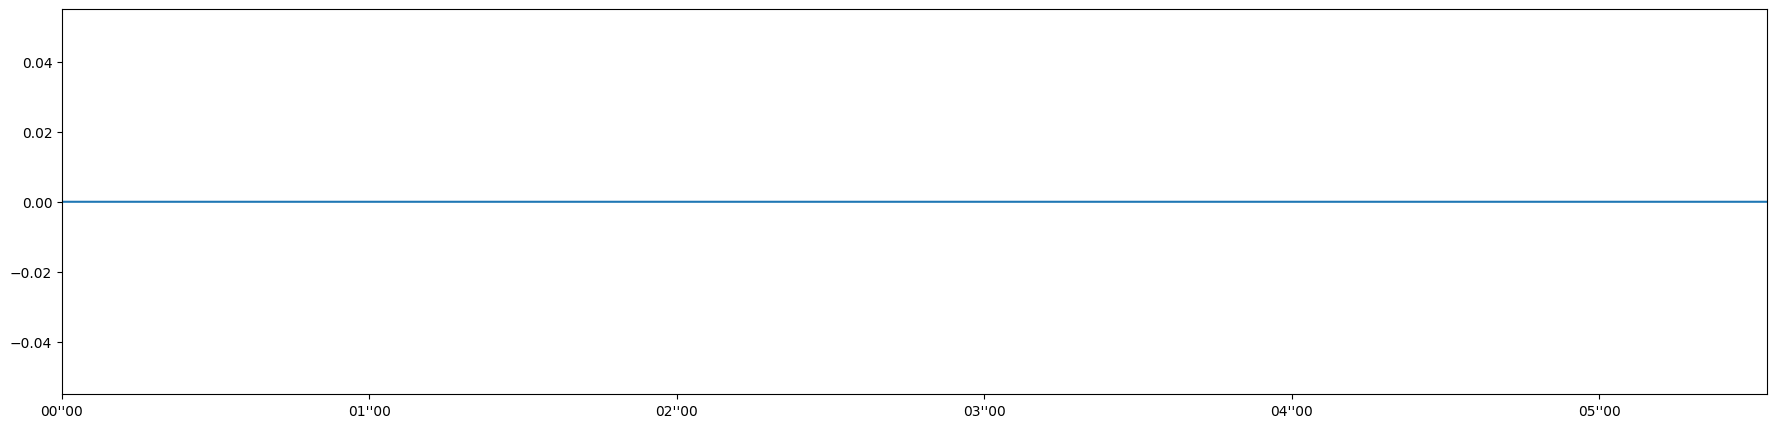

In [15]:
from hum import plot_wf
plot_wf(wf, sr)

## A simple abstract Synth

In [ ]:
# Wrapper to encapsulate value and time (optional)
class SigControl:
    def __init__(self, value=None, time=None):
        self.value = value
        self.time = time

# Wraps a SigTo object for intuitive control
class SigWrapper:
    def __init__(self, sigto_obj):
        self._sig = sigto_obj

    def __call__(self, val):
        self._sig.value = val

    def update(self, val):
        if isinstance(val, SigControl):
            if val.time is not None:
                self._sig.time = val.time
            if val.value is not None:
                self._sig.value = val.value
        else:
            self._sig.value = val

    def __getattr__(self, name):
        return getattr(self._sig, name)

    def __setattr__(self, name, val):
        if name in {"value", "time"}:
            setattr(self._sig, name, val)
        elif name == "_sig":
            super().__setattr__(name, val)
        else:
            raise AttributeError(f"Cannot set {name} on SigWrapper")

    def __repr__(self):
        return f"<SigWrapper value={self._sig.value}, time={self._sig.time}>"

# Container to simplify parameter control
class ParamSet:
    def __init__(self, param_dict):
        self._params = {k: SigWrapper(v) for k, v in param_dict.items()}

    def __getitem__(self, key):
        return self._params[key]

    def __setitem__(self, key, value):
        self._params[key].update(value)



class Synth3:
    def __init__(self, graph_func, param_specs):
        self.server = Server(audio='portaudio').boot()
        self.server.start()

        # Create SigTo controls
        raw_params = {
            name: SigTo(value=spec['value'], time=spec.get('time', 0.05))
            for name, spec in param_specs.items()
        }
        self.sound_params = ParamSet(raw_params)

        # Generate audio graph using the provided function
        self.output = graph_func(raw_params).out()

    def start(self):
        self.output.out()
        self.server.start()
        return self

    def stop(self):
        self.output.stop()
        self.server.stop()

    def __del__(self):
        self.server.stop()

    __enter__ = start
    
    def __exit__(self, exc_type, exc_value, traceback):
        self.stop()





In [ ]:
def synth_graph(params):
    osc = Sine(freq=params['freq'])
    lfo = Sine(freq=params['tempo'] / 60.0).range(0.2, 1.0)
    modulated = osc * params['amp'] * lfo
    return ButLP(modulated, freq=params['cutoff'])


param_specs = {
    'freq': {'value': 440, 'time': 0.05},
    'amp': {'value': 0.5},
    'cutoff': {'value': 1000},
    'tempo': {'value': 120},
}

obj = Synth3(synth_graph, param_specs)

Pyo warning: Portaudio input device `MacBook Pro Microphone` has fewer channels (1) than requested (2).
Pyo warning: Portmidi warning: could not open midi input 0 (IAC Driver Bus 1): PortMidi: Invalid device ID
Pyo warning: Portmidi warning: could not open midi output 1 (IAC Driver Bus 1): PortMidi: Invalid device ID
Pyo warning: Portmidi closed.
Pyo warning: The Server must be started!


In [ ]:
obj.sound_params['freq'] = 1200


In [ ]:
obj.sound_params['cutoff'] = 200  # Very muffled


In [ ]:
obj.sound_params['cutoff'] = SigControl(value=4000, time=1.0)  # Slowly brightens

In [ ]:
obj.stop()

## A concrete version of Synth

In [ ]:
from pyo import *

# Wrapper to encapsulate value and time (optional)
class SigControl:
    def __init__(self, value=None, time=None):
        self.value = value
        self.time = time

# Wraps a SigTo object for intuitive control
class SigWrapper:
    def __init__(self, sigto_obj):
        self._sig = sigto_obj

    def __call__(self, val):
        self._sig.value = val

    def update(self, val):
        if isinstance(val, SigControl):
            if val.time is not None:
                self._sig.time = val.time
            if val.value is not None:
                self._sig.value = val.value
        else:
            self._sig.value = val

    def __getattr__(self, name):
        return getattr(self._sig, name)

    def __setattr__(self, name, val):
        if name in {"value", "time"}:
            setattr(self._sig, name, val)
        elif name == "_sig":
            super().__setattr__(name, val)
        else:
            raise AttributeError(f"Cannot set {name} on SigWrapper")

    def __repr__(self):
        return f"<SigWrapper value={self._sig.value}, time={self._sig.time}>"

# Container to simplify parameter control
class ParamSet:
    def __init__(self, param_dict):
        self._params = {k: SigWrapper(v) for k, v in param_dict.items()}

    def __getitem__(self, key):
        return self._params[key]

    def __setitem__(self, key, value):
        self._params[key].update(value)

# Main synth class
class Synth2:
    def __init__(self, freq=440, amp=0.5, cutoff=1000, tempo=120):
        self.server = Server(audio='portaudio').boot()
        self.server.start()

        # Create SigTo parameters
        raw_params = {
            'freq': SigTo(value=freq, time=0.05),
            'amp': SigTo(value=amp, time=0.05),
            'cutoff': SigTo(value=cutoff, time=0.05),
            'tempo': SigTo(value=tempo, time=0.05),
        }

        self.sound_params = ParamSet(raw_params)

        # Synth processing chain
        osc = Sine(freq=raw_params['freq'])
        lfo = Sine(freq=raw_params['tempo'] / 60.0).range(0.2, 1.0)
        modulated = osc * raw_params['amp'] * lfo
        self.filtered = ButLP(modulated, freq=raw_params['cutoff'])

        self.output = self.filtered.out()

    def start(self):
        self.output.out()
        self.server.start()

    def stop(self):
        self.output.stop()
        self.server.stop()

    def __del__(self):
        self.server.stop()

In [ ]:
obj = Synth2()

Pyo warning: Portaudio input device `MacBook Pro Microphone` has fewer channels (1) than requested (2).
Pyo warning: The Server must be started!


In [ ]:
obj.sound_params['freq'] = 660  # Smoothly changes freq

In [ ]:
obj.sound_params['freq'] = SigControl(value=200, time=0.8)  # Custom time

In [ ]:
obj.sound_params['amp'].time = 0.3  # Change ramp time


In [ ]:
obj.sound_params['tempo'] = 60

In [ ]:
obj.sound_params['tempo'].play()  # Direct access to SigTo methods

< Instance of SigTo class >

In [ ]:
obj.stop()

## A simple, concrete version of Synth

In [ ]:
from pyo import *

class Synth1:
    def __init__(self, freq=440, amp=0.5, cutoff=1000, tempo=120):
        # Boot server in non-GUI, realtime mode
        self.server = Server(audio='portaudio').boot()
        self.server.start()

        # Sound parameters as SigTo for smooth changes
        self.sound_params = {
            'freq': SigTo(value=freq, time=0.05),
            'amp': SigTo(value=amp, time=0.05),
            'cutoff': SigTo(value=cutoff, time=0.05),
            'tempo': SigTo(value=tempo, time=0.05),
        }

        # Oscillator and modulations
        self.osc = Sine(freq=self.sound_params['freq'])
        self.lfo = Sine(freq=self.sound_params['tempo'] / 60.0).range(0.2, 1.0)
        modulated = self.osc * self.sound_params['amp'] * self.lfo
        self.filtered = ButLP(modulated, freq=self.sound_params['cutoff'])

        # Output
        self.output = self.filtered.out()

    def stop(self):
        self.output.stop()
        self.server.stop()

    def start(self):
        self.output.out()
        self.server.start()

    def __del__(self):
        self.server.stop()


In [ ]:
obj = Synth1()

In [ ]:
obj.sound_params['freq'].value = 300

In [ ]:
obj.stop()

In [ ]:
list(obj.sound_params)

['freq', 'amp', 'cutoff', 'tempo']